In [44]:
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import math as m
from scipy import signal
from scipy.linalg import fractional_matrix_power as matrix_power

from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler

import seaborn as sns

## Mixture data

In [45]:
# sample size and dimensionality
n, d = 5000, 2

X_1 = np.random.uniform(-np.sqrt(3),np.sqrt(3), (n))
X_2 = np.random.laplace(0, 1, (n))
X = np.vstack([X_1, X_2])
X.shape

(2, 5000)

In [46]:
def plot_densities(X_1, X_2, ax1=None, ax2=None, **kwargs):
#     plt.subplot(121)
    #plt.xlim(-5, 5)
    #plt.ylim(-5, 5)
    ax1.set_xlabel("Value")
    ax1.set_ylabel("Probability")
    ax1.grid(linestyle="dotted")
    ax1.hist(X_1, bins=50, density=True)

#     plt.subplot(122)
    #plt.xlim(-5, 5)
    #plt.ylim(-5, 5)
    ax2.grid(linestyle="dotted")
    ax2.set_xlabel("Value")
    ax2.set_ylabel("Probability")
    ax2.hist(X_2, bins=50, density=True)


Initial sources:
 [[ 0.19122122  0.10271262 -0.8942499  ...  0.87095592  1.52882718
   0.61182004]
 [-0.31909312  2.09040013 -0.59577812 ...  0.32863962 -0.01046587
   1.19820446]]

Initial mean:
 [-0.03054866  0.03474581]

Mixing matrix:
 [[ 0.34257183 -0.95563818]
 [-0.26041953  0.37059841]]

Mixed data:
 [[ 0.33989591 -1.9930284   0.23245483 ... -0.04624427  0.50318605
  -0.96600629]
 [-0.13330734  0.78269641  0.04683152 ... -0.0702748  -0.36726929
   0.31946859]]


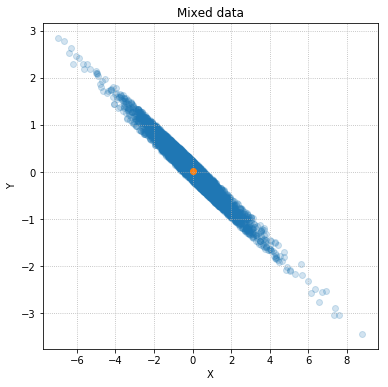

In [47]:
# set random mean
mean = np.random.normal(0, 0.5, d)

# create random mixing matrix
M = np.random.normal(0, 1, (d, d))

# mix initial sources and add mean.
Y = np.dot(M, X) + mean.reshape((2, 1))

print("\nInitial sources:\n", X)
print("\nInitial mean:\n", mean)
print("\nMixing matrix:\n", M)
print("\nMixed data:\n", Y)

fig = plt.figure(figsize=(6,6))

plt.xlabel("X")
plt.ylabel("Y")
plt.grid(linestyle="dotted")
plt.title("Mixed data")
plt.scatter(Y[0], Y[1], alpha=0.2)
plt.scatter(np.mean(Y.T, axis=0)[0], np.mean(Y.T, axis=0)[1], alpha=1)

plt.show()

In [48]:
def white(data):
    x_mean = np.mean(data, axis=1)
    data_centered = data - x_mean.reshape((2, 1))
    covariance = data_centered.dot(data_centered.T) / n
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    W = eigenvectors.dot(matrix_power(np.diag(eigenvalues), -0.5)).dot(eigenvectors.T)
    return np.dot(W, data_centered), data_centered, W

In [49]:
Y_white, Y_centered, W = white(Y)
Y_white.shape, Y_centered.shape

((2, 5000), (2, 5000))

In [80]:
def Kurtosis_ICA(Y, len_component, n_components, step=1e-2, tol=1e-10, max_iter=10000, plot=True):
    components = []
    for i in range(n_components):
        errors = []
        vector_current = np.random.rand(len_component)
        vector_current /= np.linalg.norm(vector_current)
        for iteration in range(max_iter):
            vector_new = np.copy(vector_current)
            #gradient_update
            sign = np.sign(np.mean((vector_new @ Y) ** 4) - 3)
            vector_new += step * sign * (Y @ (vector_new @ Y)**3 / Y.shape[1])
            #orthogonalization
            for  vec in components:    
                temp_vector = vec.reshape(-1, 1)
                vector_new -= vector_new.T @ (temp_vector @ temp_vector.T)
            vector_new /= np.linalg.norm(vector_new)
            
            errors.append(np.linalg.norm(vector_current - vector_new))
            if np.linalg.norm(vector_current - vector_new) <= tol:
                if plot:
                    plt.title('Component {}'.format(i))
                    plt.plot(errors)
                    plt.xlabel('n_iter')
                    plt.show()
                components.append(vector_new)
                break
            else:
                vector_current = vector_new
                
        if iteration == max_iter - 1:
            components.append(vector_current)
    return np.vstack(components)

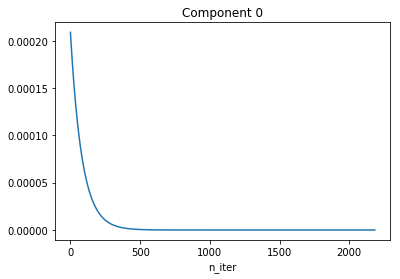

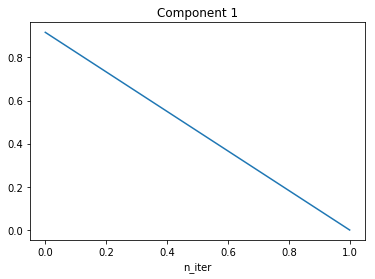

In [81]:
W = Kurtosis_ICA(Y_white, 2, n_components=2, tol=1e-15)

In [82]:
recovered_signals = W @ Y_white

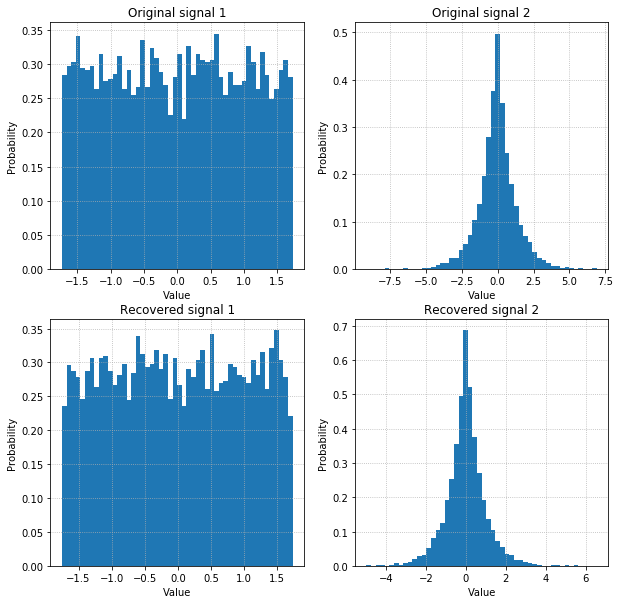

In [83]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax1.set_title('Original signal 1')
ax2.set_title('Original signal 2')
ax3.set_title('Recovered signal 1')
ax4.set_title('Recovered signal 2')
plot_densities(X_1, X_2, ax1, ax2)
plot_densities(recovered_signals[0, :], recovered_signals[1, :], ax3, ax4)

We can see that up to a scaling coeffecient recovered signals are nicely estimated

## 4.1. Blind source separation

In [100]:
# set image size
shape = (512, 512)
rows, cols = shape

# load images
img1 = np.load('./data/camera.npy').flatten()
img2 = np.load('./data/astronaut.npy').flatten()
img3 = np.load('./data/moon.npy').flatten()
img4 = np.load('./data/noise.npy').flatten()

# combine images
S = np.c_[img1, img2, img3, img4].T

In [101]:
# set random mixing matrix A
A = np.random.uniform(0.2, 0.8, (4, 4))

# mix data
X = np.dot(A, S)

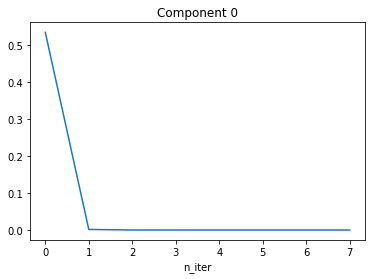

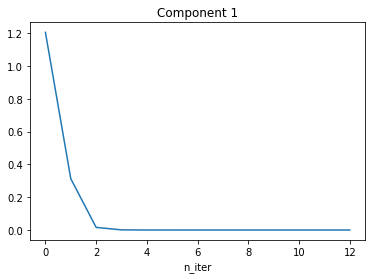

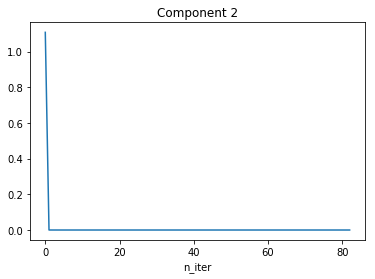

In [102]:
W_image = Kurtosis_ICA(X, 4, 3, tol=1e-15)

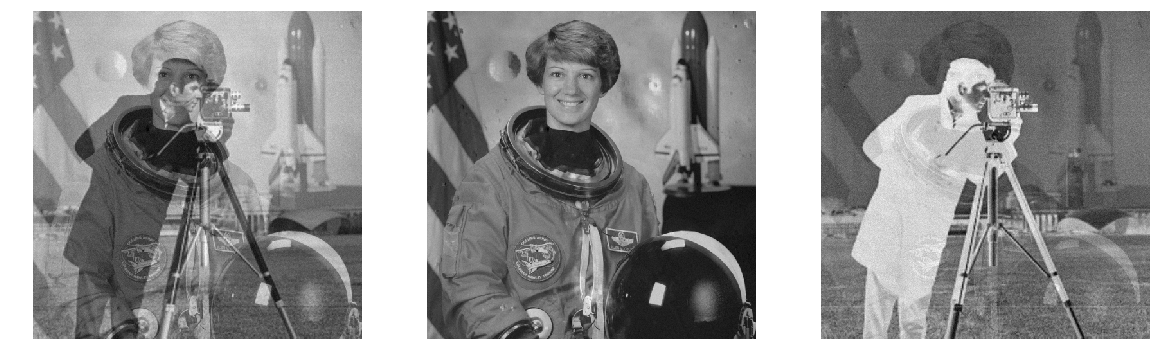

In [103]:
recovered_images = W_image @ X

f, ax = plt.subplots(1, 3, figsize=(20, 10))
for i in range(3):
    ax[i].imshow(recovered_images[i].reshape(shape), cmap=plt.gray())
    ax[i].axis('off')

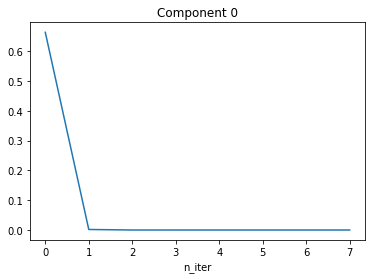

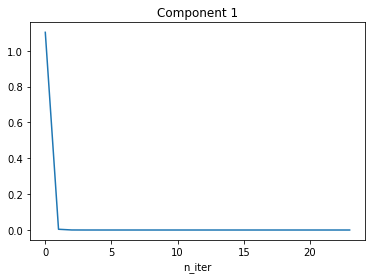

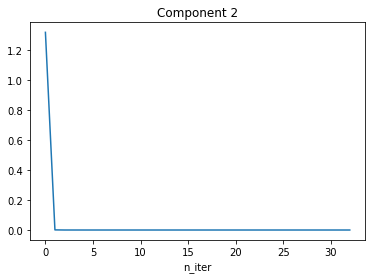

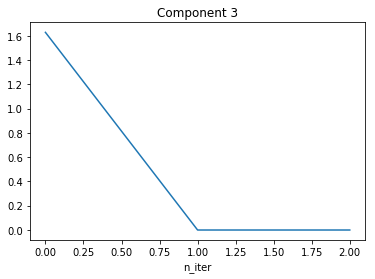

In [104]:
W_image_4 = Kurtosis_ICA(X, 4, 4, tol=1e-15)

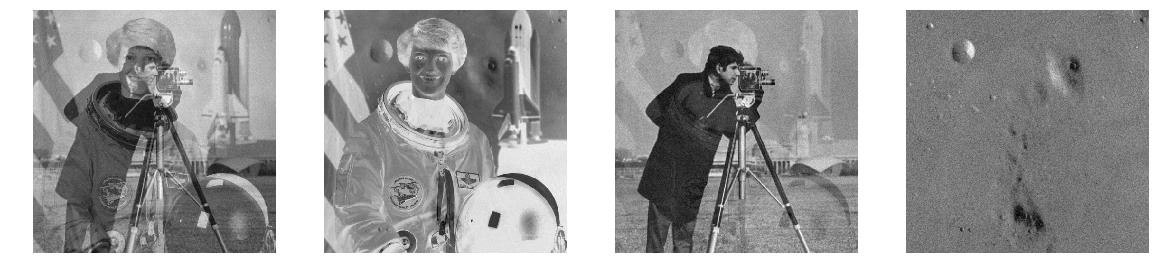

In [105]:
recovered_images_4 = W_image_4 @ X
f, ax = plt.subplots(1, 4, figsize=(20, 10))
for i in range(4):
    ax[i].imshow(recovered_images_4[i].reshape(shape), cmap=plt.gray())
    ax[i].axis('off')
plt.show()

## 4.2. Time series

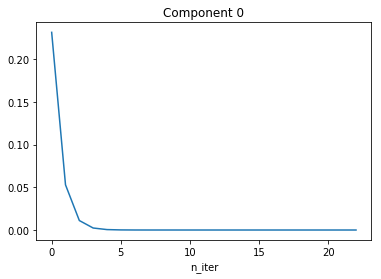

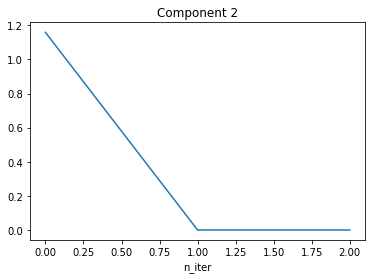

In [106]:
np.random.seed(42)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3.5 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(1.5 * np.pi * time) # sawtooteh

S = np.c_[s1, s2, s3]
#S += np.array([0, 0, np.random.normal()])  # Add noise

S /= S.std(axis=0)  # Standardize data

# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
#A = np.random.normal(0, 1, (3, 3))
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
W_time = Kurtosis_ICA(X.T, 3, 3, tol=1e-15)
S_ = X @ W_time.T
#A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
#assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

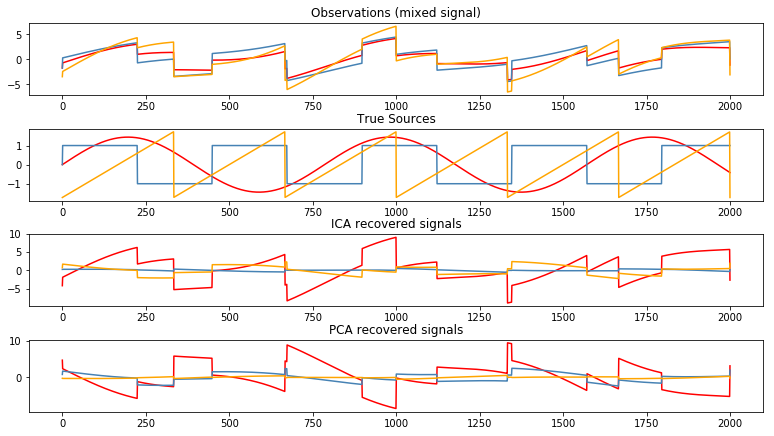

In [107]:
fig = plt.figure(figsize=(12,6))

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()

### Analysis for different steps sizes

###  Mixture data

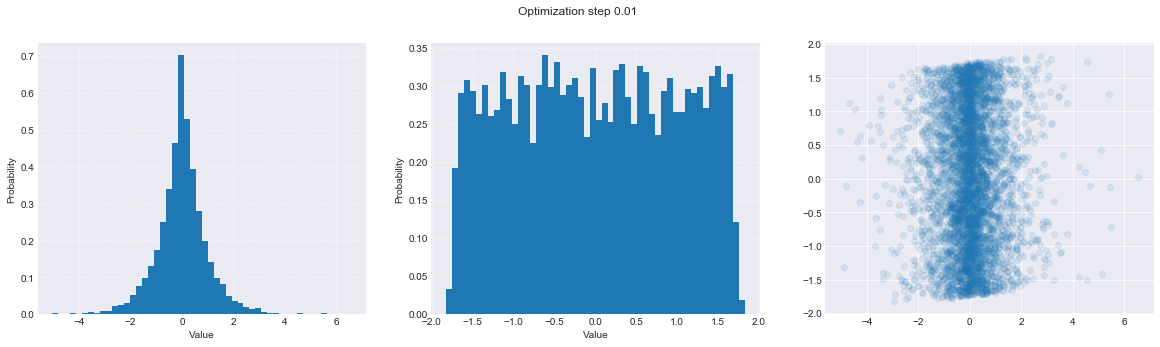

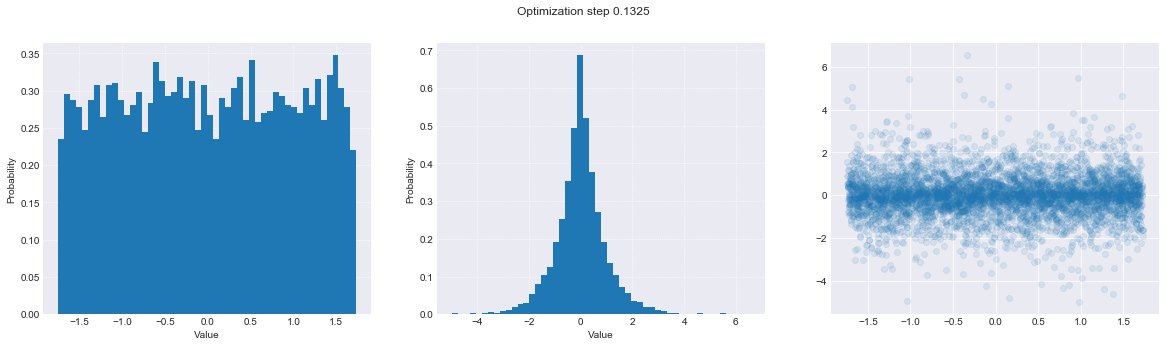

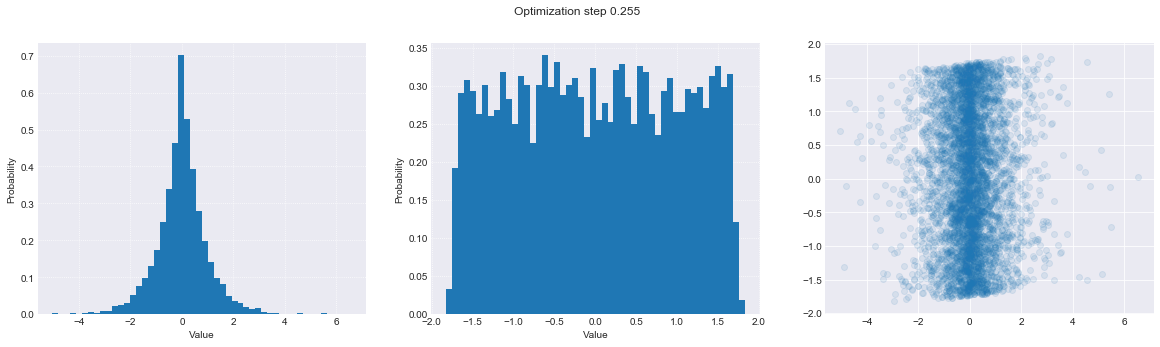

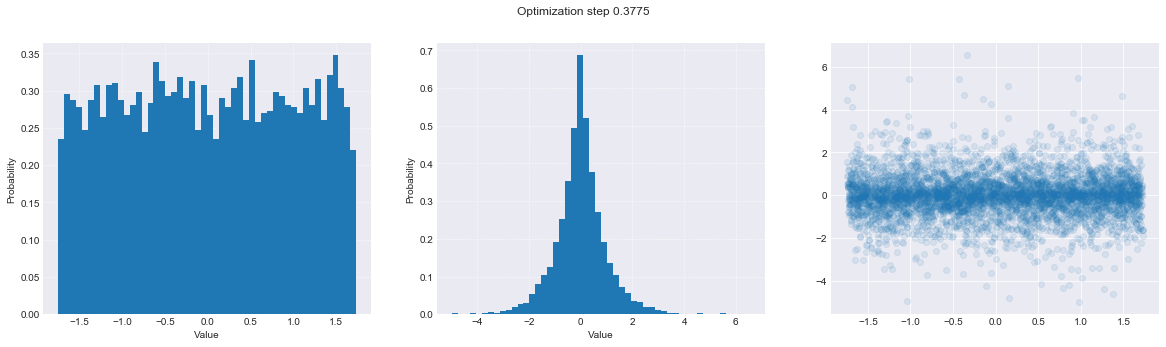

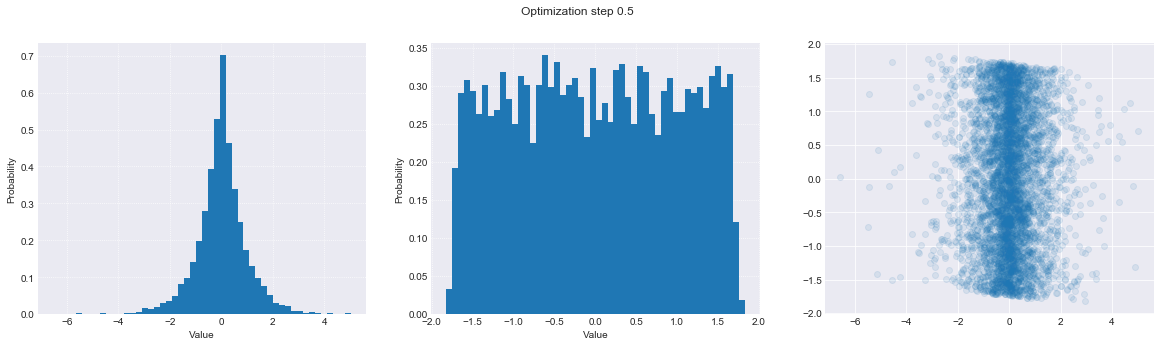

In [109]:
for optimization_step in np.linspace(0.01, 0.5, num=5):
    with sns.axes_style('darkgrid'):
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
        W_step_mixture = Kurtosis_ICA(Y_white, 2, 2, step=optimization_step, plot=False)
        separated = W_step_mixture @ Y_white
        plot_densities(separated[0, :], separated[1, :], ax1, ax2)
        ax3.scatter(separated[0, :], separated[1, :], alpha=0.1)
        f.suptitle('Optimization step {}'.format(optimization_step))
        plt.show()

### Time series

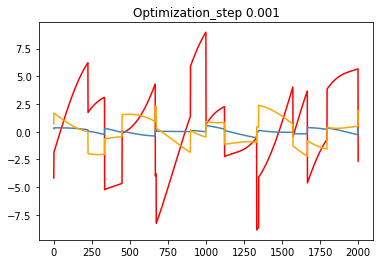

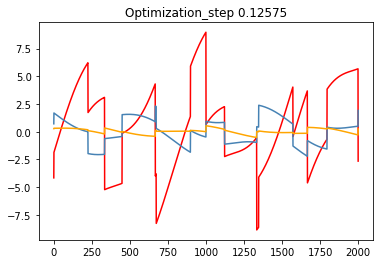

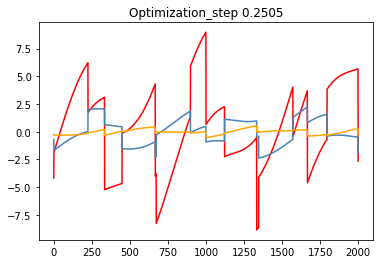

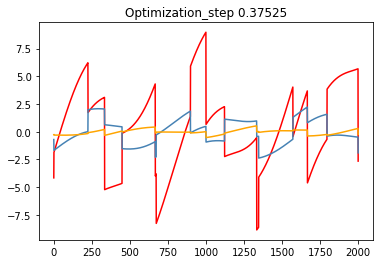

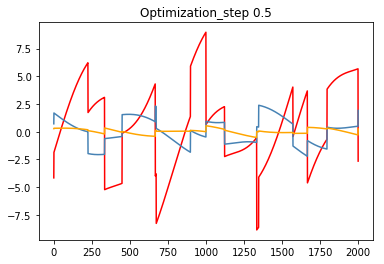

In [113]:
for optimization_step in np.linspace(0.001, 0.5, num=5):
    W_time = Kurtosis_ICA(X.T, 3, 3, step=optimization_step, tol=1e-11, plot=False)
    S_ = X @ W_time.T
    plt.figure()
    for sig, color in zip(S_.T, colors):
        plt.plot(sig, color)
        plt.title('Optimization_step {}'.format(optimization_step))
    plt.show()